In [243]:
import pandas as pd
import numpy as np
import csv
import os
import re
from collections import defaultdict
import dateutil.parser
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import calendar

# CHALLENGE 1

In [245]:
mtaDict = defaultdict(list)

with open("/home/rachaelrho/ds/metis/bensonChallenges/mtaFiles/turnstile_160402.csv") as csvfile:
    reader = csv.reader(csvfile)
    reader.next()
    for row in reader:
        CA = row[0]
        UNIT = row[1]
        SCP = row[2]
        STATION = row[3]
        LINENAME = row[4]
        DIVISION = row[5]
        DATE = row[6]
        TIME = row[7]
        DESC = row[8]
        ENTRIES = row[9]
        EXITS = row[10]
        mtaDict[(CA, UNIT, SCP, STATION)].append([LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS])

# CHALLENGE 2

In [246]:
mtaDict1 = defaultdict(list)

for key in mtaDict.iterkeys():
    newList = []
    for i in range(1,len(mtaDict[key]),1):
        date = mtaDict[key][i][2]
        time = mtaDict[key][i][3]
        newDateTime = datetime.strptime(date + " " + time, '%m/%d/%Y %H:%M:%S')
        entry = int(mtaDict[key][i][5])
        newLine = newDateTime, entry
        newList.append(newLine)
    mtaDict1[(key)] = newList

# CHALLENGE 3

In [247]:
mtaDict1_count = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1],
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in mtaDict1.items()}    #make a new dictionary; keys will be the turnstiles, each will have a list of lists, each of which will give date, change in entries from last time, and elasped time

In [248]:
datetime_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in mtaDict1_count.items()}    

# CHALLENGE 4

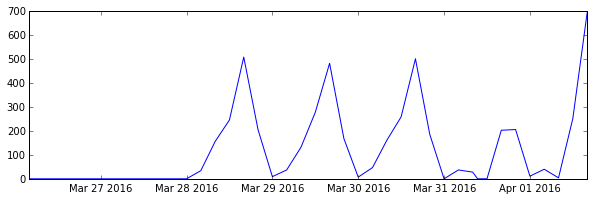

In [249]:
turnstile = ('A002','R051','02-00-00','59 ST')

dates = [i[0] for i in datetime_counts[('A002','R051','02-00-00','59 ST')]]
counts = [i[1] for i in datetime_counts[('A002','R051','02-00-00','59 ST')]]

plt.figure(figsize=(10,3))
plt.plot(dates,counts)


# Using pandas for challenges 5 through 10

In [250]:
filepaths = ["/home/rachaelrho/ds/metis/bensonChallenges/mtaFiles/turnstile_160402.csv",
         "/home/rachaelrho/ds/metis/bensonChallenges/mtaFiles/turnstile_160326.csv",
         "/home/rachaelrho/ds/metis/bensonChallenges/mtaFiles/turnstile_160319.csv"]

mtaData = pd.concat((pd.read_csv(file)) for file in filepaths)

In [254]:
mtaData = mtaData.rename(columns={'EXITS                                                               ':'EXITS'})

In [255]:
mtaData['DATE'] = pd.to_datetime(mtaData['DATE'])

In [256]:
stationGroupBy = mtaData.groupby(['C/A','UNIT','SCP','STATION'])

for i in ('ENTRIES', 'EXITS'):
    mtaData[i + '_diff'] = stationGroupBy[i].transform(pd.Series.diff)


In [257]:
mtaData = mtaData.dropna(subset = ['ENTRIES'])
mtaData = mtaData[mtaData.ENTRIES_diff > 0]

# CHALLENGE 5

In [258]:
dateGroupBy = mtaData.groupby(['C/A','UNIT','STATION','DATE'], as_index=False)
mtaData1 = dateGroupBy[['ENTRIES_diff', 'EXITS_diff']].sum()
mtaData1.head(3)

,C/A,UNIT,STATION,DATE,ENTRIES_diff,EXITS_diff
0,A002,R051,59 ST,2016-03-12,10763,6324
1,A002,R051,59 ST,2016-03-13,7351,4625
2,A002,R051,59 ST,2016-03-14,15199,9920


# CHALLENGE 6

In [259]:
stationData = mtaData.groupby(['STATION','DATE'], as_index = False)[['ENTRIES_diff', 'EXITS_diff']].sum()

stations = stationData.STATION.unique()
#num_lists = len(stations)
timeSeriesLists = []

for station in stations:
    #for i in range(num_lists):
    data = stationData[stationData.STATION == station]
    timeSeries = np.array(data[['DATE','ENTRIES_diff']])
    timeSeriesLists.append(timeSeries)


# CHALLENGE 7

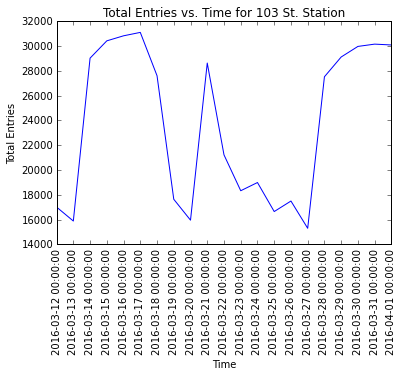

In [260]:
station = stationData[stationData.STATION == '103 ST']
z = np.array(station[['DATE','ENTRIES_diff']])
timeSeries = zip(*z)
xLabel = timeSeries[0]
plt.xticks(timeSeries[0],xLabel, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('Total Entries')
plt.title("Total Entries vs. Time for 103 St. Station")
plt.plot(timeSeries[0],timeSeries[1])


# CHALLENGE 8

/home/rachaelrho/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


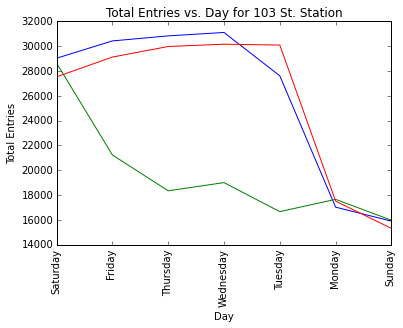

In [261]:
station = stationData[stationData.STATION == '103 ST']
station['DAY'] = station['DATE'].dt.dayofweek ##.apply(lambda x: calendar.day_name[x])

##plot

plt.clf()

week_count_list1 = station.loc[station['DATE'] <= '2016-03-18 00:00:00']
week_count_list1 = week_count_list1.sort('DAY', ascending = False)
week_count_list2 = station.loc[(station['DATE'] >= '2016-03-19 00:00:00') & (station['DATE'] <= '2016-03-25 00:00:00')]
week_count_list2 = week_count_list2.sort('DAY', ascending = False)
week_count_list3 = station.loc[(station['DATE'] >= '2016-03-26 00:00:00') & (station['DATE'] <= '2016-04-01 00:00:00')]
week_count_list3 = week_count_list3.sort('DAY', ascending = False)

plt.plot(week_count_list1['DAY'],week_count_list1['ENTRIES_diff'])
plt.plot(week_count_list2['DAY'],week_count_list2['ENTRIES_diff'])
plt.plot(week_count_list3['DAY'],week_count_list3['ENTRIES_diff'])

xLabel = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.xticks(week_count_list1['DAY'],xLabel, rotation = 'vertical')
plt.xlabel('Day')
plt.ylabel('Total Entries')
plt.title("Total Entries vs. Day for 103 St. Station")

# CHALLENGE 9

In [262]:
stationDataTotal = stationData.groupby(['STATION'], as_index = False)[['ENTRIES_diff']].sum()
stationDataTotal = stationDataTotal.sort('ENTRIES_diff', ascending = False)
stationDataTotal

,STATION,ENTRIES_diff
23,167 ST,1771791282
63,36 ST,302374510
69,45 ST,285243882
61,34 ST-PENN STA,237858383
247,JAMAICA 179 ST,235290772
104,8 ST-NYU,134539741
189,COURT SQ,117698790
122,ATL AV-BARCLAY,66589320
286,NASSAU ST,50612422
52,28 ST,12163901


# CHALLENGE 10

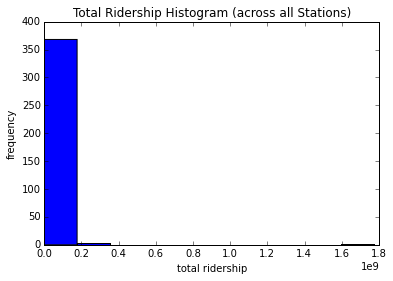

In [263]:
total_ridership_counts = np.array(stationDataTotal.ENTRIES_diff)

plt.hist(total_ridership_counts)
plt.title('Total Ridership Histogram (across all Stations)')
plt.xlabel('total ridership')
plt.ylabel('frequency')